## Time Gaps

Calculating intra- and inter-night gaps for several cadences

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots 
import shutil

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = False

In [3]:
surveyDuration=10
if surveyDuration < 10:
    year = 3
    sqlconstraint = 'night between %f and %f' % ((365.25*year,365.25*(year+1)))
else:
    sqlconstraint = ''
if False:
    if len(sqlconstraint):
        sqlconstraint += ' and filter = "r"'
    else:
        sqlconstraint = 'filter = "r"'

In [4]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=16)

# Configure some metrics
metricList = []
# Intra-night gaps
m1 = metrics.IntraNightGapsMetric()
metricList.append(m1)
# Inter-night gaps
m2 = metrics.InterNightGapsMetric()
metricList.append(m2)
# Gap histogram
m3 = metrics.AveGapMetric()
metricList.append(m3)

# summaryMetrics
summaryMetrics = [metrics.MinMetric(), metrics.MeanMetric(), metrics.MaxMetric(), 
                  metrics.MedianMetric(), metrics.RmsMetric(), 
                 metrics.PercentileMetric(percentile=25), metrics.PercentileMetric(percentile=75)]

# suppress angular power spectrum plots
plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


minion_1016
Querying database with no constraint.
Found 2447931 visits
Running:  [0, 1, 2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  sqlconstraint now.
Plotting complete.
enigma_1282
Querying database with no constraint.
Found 2396597 visits
Running:  [0, 1, 2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  sqlconstraint now.


/smallfiles/ebellm/anaconda/envs/maf/opt/lsst/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 757 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.
kraken_1043
Querying database with no constraint.
Found 2509335 visits
Running:  [0, 1, 2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  sqlconstraint now.
Plotting complete.
minion_1020
Querying database with no constraint.
Found 2429023 visits
Running:  [0, 1, 2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  sqlconstraint now.


/smallfiles/ebellm/anaconda/envs/maf/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting complete.


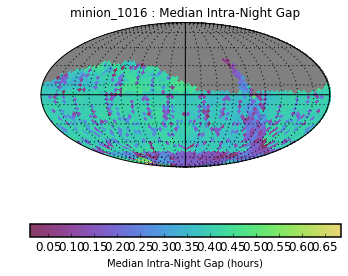

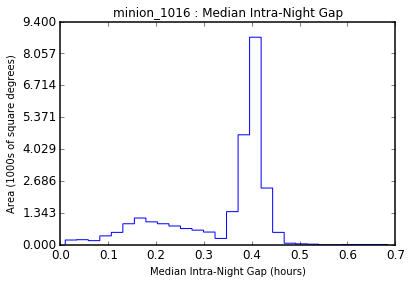

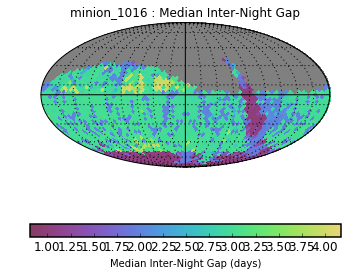

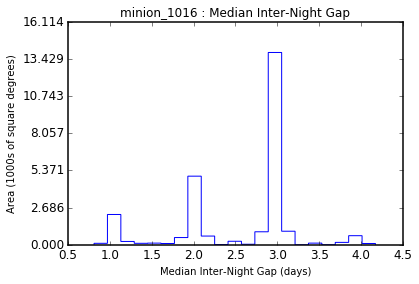

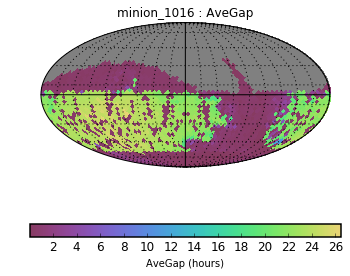

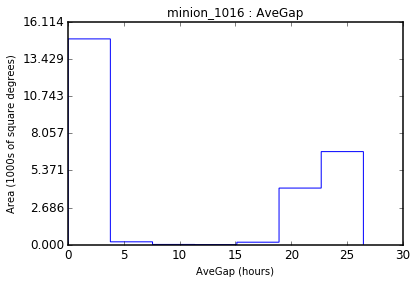

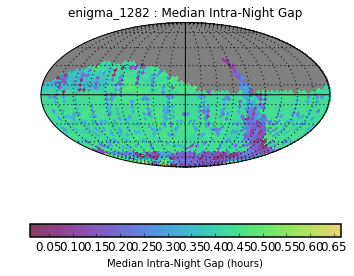

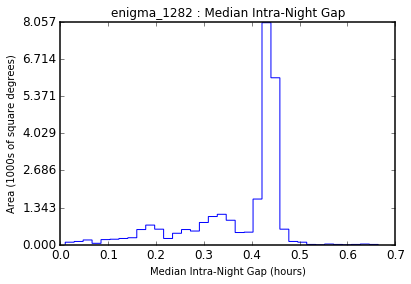

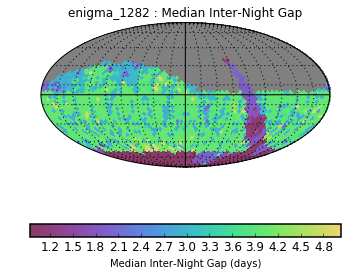

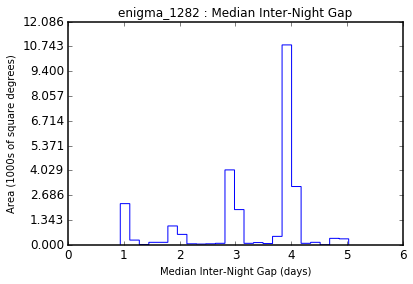

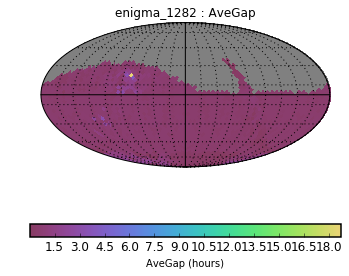

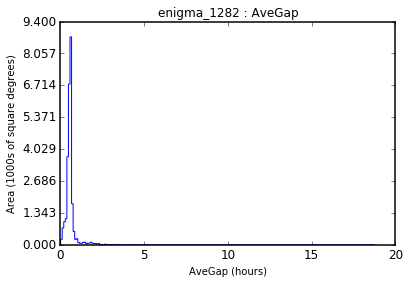

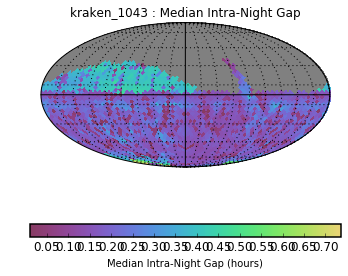

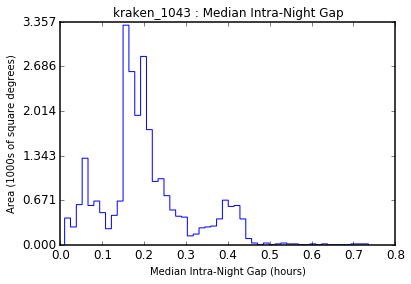

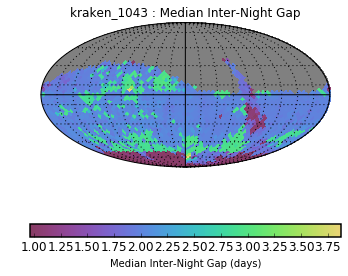

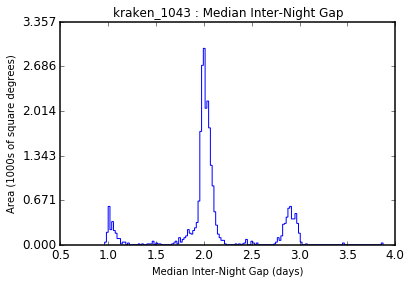

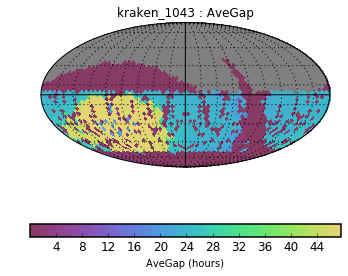

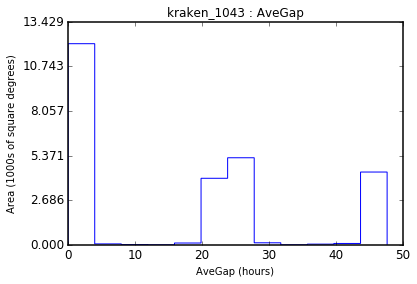

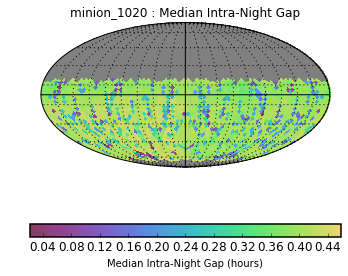

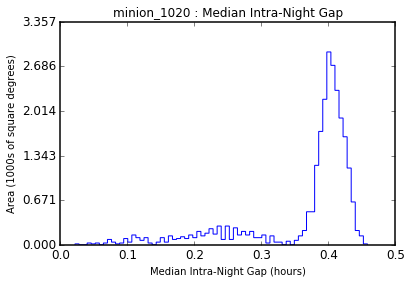

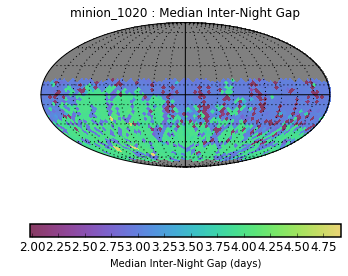

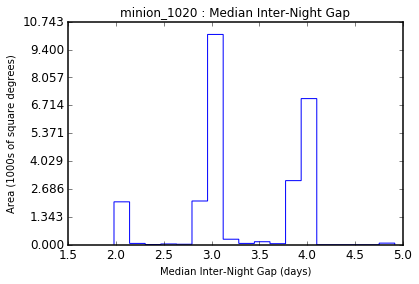

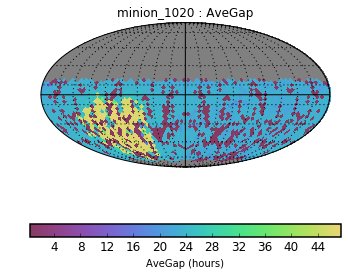

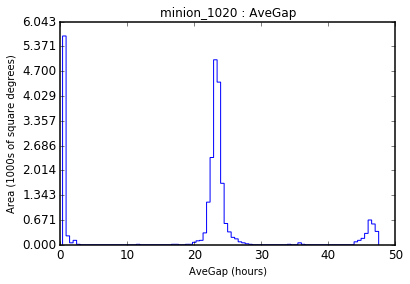

In [5]:
# Choose the opsim runs and do them all!
runs = ['minion_1016', # baseline cadence
        'enigma_1282', # NEO with triples
        'kraken_1043', # no visit pairs
        'minion_1020'] # PS-like

outDir = 'gaps'

# resultsdb will contain multiple runs with various values if we change sqlconstraints, etc.  Instead, delete so 
# we have a clean directory

shutil.rmtree('./'+outDir+'/')

bDictDict = {}

for runName in runs:
    print runName
    opsdb = db.OpsimDatabase(runName + '_sqlite.db')
    resultsDb = db.ResultsDb(outDir=outDir)
    
    # build the bundleDict
    bDict={}
    for i,metric in enumerate(metricList):
        bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
            runName=runName, summaryMetrics=summaryMetrics, plotFuncs=plotFuncs)

    bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
    bgroup.runAll()
    bgroup.plotAll(closefigs=False)
    bDictDict[runName] = bDict

In [34]:
metric_names = []
for runName in runs:
    print runName
    bDict = bDictDict[runName]
    for key in sorted(bDict):
        bDict[key].computeSummaryStats(resultsDb=resultsDb)
        print bDict[key].metric.name, bDict[key].summaryValues
        metric_names.append(bDict[key].metric.name)
    print 
metric_names=set(metric_names)

minion_1016
Median Intra-Night Gap {'25th%ile': 0.26281800004653633, 'Rms': 0.10728272445723894, '75th%ile': 0.40872900000249501, 'Min': 0.01000799989560619, 'Max': 0.68457599994144402, 'Median': 0.39106800002628006, 'Mean': 0.33777760945463087}
Median Inter-Night Gap {'25th%ile': 2.027508874999512, 'Rms': 0.69652257531499306, '75th%ile': 2.9997029999994993, 'Min': 0.81021600000167382, 'Max': 4.17251099999703, 'Median': 2.9539277499989112, 'Mean': 2.5793498419835448}
AveGap {'25th%ile': 0.49047599997720681, 'Rms': 11.001780779566692, '75th%ile': 22.777800000098068, 'Min': 0.01000799989560619, 'Max': 26.461512000008952, 'Median': 1.2935460000007879, 'Mean': 10.132220250769954}

enigma_1282
Median Intra-Night Gap {'25th%ile': 0.32641499996680068, 'Rms': 0.10271865533220985, '75th%ile': 0.44078999996418133, 'Min': 0.01000799989560619, 'Max': 0.6644879998639226, 'Median': 0.42842400001245551, 'Mean': 0.37435106269286356}
Median Inter-Night Gap {'25th%ile': 2.9352188749980996, 'Rms': 0.9948

In [35]:
metric_names

{'AveGap', 'Median Inter-Night Gap', 'Median Intra-Night Gap'}

In [29]:
# these take awhile to run, so save them!
#import pickle
#output = open(outDir+'/bDictDict.pkl','wb')
#pickle.dump(bDictDict,output)
#output.close()

In [38]:
colors = {'minion_1016':'black', # baseline cadence
        'enigma_1282':'blue', # NEO with triples
        'kraken_1043':'green', # no visit pairs
        'minion_1020':'red'} # PS-like

In [39]:
def plot_metric_byruns(metricName, bDictDict, cumulative=False):
    # loop over runs to make a new bundle list with only the right metrics
    new_bundle = []
    for runName in runs:
        bDict = bDictDict[runName]
        for key in sorted(bDict):
            bDict[key].computeSummaryStats(resultsDb=resultsDb)
            if bDict[key].metric.name == metricName:
                new_bundle.append(bDict[key])
    
    # Set up the plotHandler.
    ph = plots.PlotHandler(outDir=outDir, resultsDb=resultsDb)
    # Instantiate the healpix histogram plotter, since we'll use it a lot.
    healpixhist = plots.HealpixHistogram()
    for bundle in new_bundle:
        bundle.setPlotDict({'cumulative': cumulative,'color':colors[bundle.runName]})
    ph.setMetricBundles(new_bundle)
    # Add min/max values to the plots, which will be used for the combo histogram for nvisits.
    #ph.setPlotDicts(nvisitsPlotRanges)
    ph.plot(plotFunc=healpixhist)
    fname = metric
    plt.savefig(outDir+'/'+ "".join(metricName.split())+'.pdf')

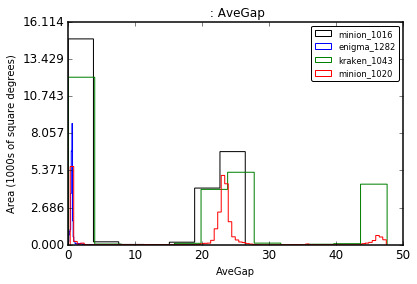

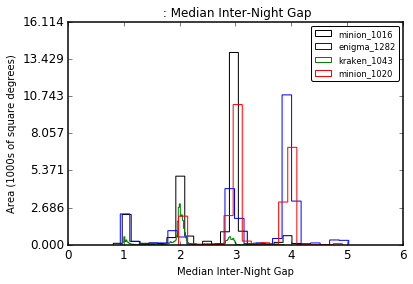

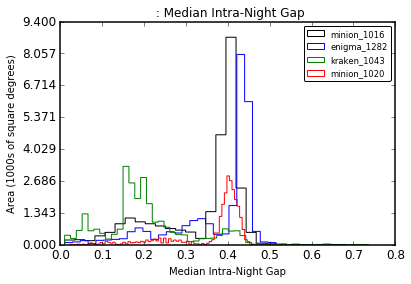

In [40]:
for metricName in metric_names:
    plot_metric_byruns(metricName,bDictDict)

In [11]:
rundb = db.ResultsDb(database=outDir+'/resultsDb_sqlite.db')

In [12]:
import pandas as pd

In [13]:
simDataName = [m[0] for m in rundb.session.query(db.MetricRow.simDataName).all()]
info = rundb.getMetricDisplayInfo()
dfi = pd.DataFrame(info)
dfi['simDataName'] = pd.Series(simDataName,index=dfi.index)
dfi.head()

,metricId,metricName,baseMetricNames,slicerName,sqlConstraint,metricMetadata,metricDatafile,displayGroup,displaySubgroup,displayOrder,displayCaption,simDataName
0,1,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,,,minion_1016_Median_Intra-Night_Gap_HEAL.npz,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016
1,2,Median Inter-Night Gap,Median Inter-Night Gap,HealpixSlicer,,,minion_1016_Median_Inter-Night_Gap_HEAL.npz,NULL,NULL,0.0,Median Inter-Night Gap calculated on a Healpix...,minion_1016
2,3,AveGap,AveGap,HealpixSlicer,,,minion_1016_AveGap_HEAL.npz,NULL,NULL,0.0,"AveGap calculated on a HealpixSlicer basis, us...",minion_1016
3,4,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,,,enigma_1282_Median_Intra-Night_Gap_HEAL.npz,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,enigma_1282
4,5,Median Inter-Night Gap,Median Inter-Night Gap,HealpixSlicer,,,enigma_1282_Median_Inter-Night_Gap_HEAL.npz,NULL,NULL,0.0,Median Inter-Night Gap calculated on a Healpix...,enigma_1282


In [14]:
stats = rundb.getSummaryStats()
dfs = pd.DataFrame(stats)
dfs.head()

,metricId,metricName,slicerName,metricMetadata,summaryName,summaryValue
0,1,Median Intra-Night Gap,HealpixSlicer,,Min,0.010008
1,1,Median Intra-Night Gap,HealpixSlicer,,Mean,0.337778
2,1,Median Intra-Night Gap,HealpixSlicer,,Max,0.684576
3,1,Median Intra-Night Gap,HealpixSlicer,,Median,0.391068
4,1,Median Intra-Night Gap,HealpixSlicer,,Rms,0.107283


In [15]:
df = pd.merge(dfs[['metricId','summaryName','summaryValue']],dfi,on='metricId')
df.head()

,metricId,summaryName,summaryValue,metricName,baseMetricNames,slicerName,sqlConstraint,metricMetadata,metricDatafile,displayGroup,displaySubgroup,displayOrder,displayCaption,simDataName
0,1,Min,0.010008,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,,,minion_1016_Median_Intra-Night_Gap_HEAL.npz,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016
1,1,Mean,0.337778,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,,,minion_1016_Median_Intra-Night_Gap_HEAL.npz,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016
2,1,Max,0.684576,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,,,minion_1016_Median_Intra-Night_Gap_HEAL.npz,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016
3,1,Median,0.391068,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,,,minion_1016_Median_Intra-Night_Gap_HEAL.npz,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016
4,1,Rms,0.107283,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,,,minion_1016_Median_Intra-Night_Gap_HEAL.npz,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016


In [16]:
print set(df['simDataName'])
print set(df['sqlConstraint'])
print set(df['metricName'])

set([u'minion_1016', u'enigma_1282', u'kraken_1043', u'minion_1020'])
set([''])
set(['AveGap', 'Median Inter-Night Gap', 'Median Intra-Night Gap'])


In [17]:
for simName in set(df['simDataName']):
    print simName
    w = (df['simDataName'] == simName) & (df['sqlConstraint'] == 'night between 1095.750000 and 1461.000000 and filter = "r"') & (df['summaryName'] == 'Median')
    print df[w][['metricName','summaryValue']]

minion_1016
Empty DataFrame
Columns: [metricName, summaryValue]
Index: []
enigma_1282
Empty DataFrame
Columns: [metricName, summaryValue]
Index: []
kraken_1043
Empty DataFrame
Columns: [metricName, summaryValue]
Index: []
minion_1020
Empty DataFrame
Columns: [metricName, summaryValue]
Index: []
